In [ ]:
#Jeremy Brouillet

#### Introduction
This notebook is for the Kaggle Competition on COVID forecasting (https://www.kaggle.com/c/covid19-global-forecasting-week-3). The data set is the John Hopkins dataset of COVID confirmed cases and fatalities across the world. The goal of the competition was to predict future confirmed cases and fatalities. 

#### Choice of model:
Based on the inherent mathematics behind the spread of viruses, I chose to use a logistic function to make predictions. We know that initially there was no COVID, and at some point it will saturate as it spreads. In between these extremes, there will be exponential growth followed by a slowdown. Additionally, the logistic model is easily interpretable. 

#### Disclaimer:
I am not an epidimologist. This notebook was strictly meant for a data science competition. It should not be used to inform emergency response or medical practices. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import scipy
from sklearn import linear_model
from scipy.optimize import curve_fit
import math
from sklearn.linear_model import LinearRegression

In [3]:
# Import data files.
train = pd.read_csv('~/projects/kaggle/covid19/input/covid19-global-forecasting-week-3/train.csv')
test = pd.read_csv('~/projects/kaggle/covid19/input/covid19-global-forecasting-week-3/test.csv')
submission = pd.read_csv('~/projects/kaggle/covid19/input/covid19-global-forecasting-week-3/submission.csv')


In [6]:
#Rename columns
train.rename(columns={'Country_Region':'Country'}, inplace=True)
test.rename(columns={'Country_Region':'Country'}, inplace=True)

train.rename(columns={'Province_State':'State'}, inplace=True)
test.rename(columns={'Province_State':'State'}, inplace=True)

train['Date'] = pd.to_datetime(train['Date'], infer_datetime_format=True)
test['Date'] = pd.to_datetime(test['Date'], infer_datetime_format=True)

#Days were counted from the first global incidence of COVID-19
FIRST_COVID_DATE = pd.to_datetime('2019-11-17', infer_datetime_format=True) 
#Source : https://www.theguardian.com/world/2020/mar/13/first-covid-19-case-happened-in-november-china-government-records-show-report

train['DaysNumber']=(train['Date'].map(lambda x: (x - FIRST_COVID_DATE).days))
test['DaysNumber']=(test['Date'].map(lambda x: (x - FIRST_COVID_DATE).days))


In [7]:
test.head()

,ForecastId,State,Country,Date,DaysNumber
0,1,NaN,Afghanistan,2020-03-26,130
1,2,NaN,Afghanistan,2020-03-27,131
2,3,NaN,Afghanistan,2020-03-28,132
3,4,NaN,Afghanistan,2020-03-29,133
4,5,NaN,Afghanistan,2020-03-30,134


In [8]:
train.head()

,Id,State,Country,Date,ConfirmedCases,Fatalities,DaysNumber
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,66
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,67
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,68
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,69
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,70


In [79]:
#Overall structure:
#for country, state
    #fit each curve
    #make prediction
    #estimate log-loss
#write output
def logisticR(x, a, b, c):
     return a / (1 + np.exp(-(x-b)*c))

#Initialize submission Calc
train_calc = pd.DataFrame(columns = ['ForecastId', 'ConfirmedCases','Fatalities'])
test_calc = pd.DataFrame(columns = ['ForecastId', 'ConfirmedCases','Fatalities'])
optimalparamsAll = pd.DataFrame(columns = ['Country','State','ParamsFatalities','ParamsCases','CovFatalities','CovCases'])

# Find trends by state
for country in set(train['Country']):   
    train_country = (train.loc[train['Country']==country])
    test_country = (test.loc[test['Country']==country])
    for state in set(train_country["State"]):
        if type(state)==float:
            train_state = train_country.loc[train_country['State'].map(lambda x: type(x)==float)]
            test_state =  test_country.loc[test_country['State'].map(lambda x: type(x)==float)]
            state_name = ''
        else:
            train_state = (train_country.loc[train_country['State']==state])
            test_state = (test_country.loc[test_country['State']==state])
            state_name = state

# Seperate out train/test data            
        xtrain = train_state["DaysNumber"]
        ytrainfatalities = train_state["Fatalities"]
        ytrainconfirmedcases = train_state["ConfirmedCases"]
        xtest = test_state["DaysNumber"]   

# Fit data to logistic to a logistic function
# Reasonable initial conditions and bounds were chosen.
        optimalparamsCC, pcovarianceCC = curve_fit(logisticR, xtrain, ytrainconfirmedcases, maxfev=5000, p0=[0,130,.2], bounds = ([0,0,.08],[2000000,175,1]))
        maxDeaths = optimalparamsCC[0]  
        
#Offsets: Fatalities starting point based on the cases
#The number of fatalities will be upper bounded by the number of confirmed cases
        startingPoint = [optimalparamsCC[0]*0.03,optimalparamsCC[1]+8,optimalparamsCC[2]]
        optimalparamsfatalities, pcovariancefatalities = curve_fit(logisticR, xtrain, ytrainfatalities, maxfev=5000, p0=startingPoint, bounds = ([0,0,.08],[maxDeaths,183,1]))

# Calculate out predictions
        ytrainestimatedfatalities=logisticR(xtrain, *optimalparamsfatalities)
        ytrainestimatedCC=logisticR(xtrain, *optimalparamsCC)
        ytestestimatedfatalities=logisticR(xtest, *optimalparamsfatalities)
        ytestestimatedCC=logisticR(xtest, *optimalparamsCC)
        
        train_calc_add = pd.DataFrame(columns = ['Id', 'ConfirmedCases','Fatalities'])
        train_calc_add["Fatalities"] = ytrainestimatedfatalities
        train_calc_add["ConfirmedCases"] = ytrainestimatedCC
        train_calc_add["Id"] = train_state["Id"]
        train_calc=train_calc.append(train_calc_add)
        
        
        test_calc_add = pd.DataFrame(columns = ['ForecastId', 'ConfirmedCases','Fatalities'])
        test_calc_add["Fatalities"] = ytestestimatedfatalities
        test_calc_add["ConfirmedCases"] = ytestestimatedCC
        test_calc_add["ForecastId"] = test_state["ForecastId"]
        test_calc=test_calc.append(test_calc_add)

        optimalparams_add = pd.DataFrame({'Country':[country],'State':[state],'ParamsFatalities':[optimalparamsfatalities],'ParamsCases':[optimalparamsCC],
                              'CovFatalities':[pcovariancefatalities],'CovCases':[pcovarianceCC]})
        optimalparamsAll = pd.concat([optimalparamsAll, optimalparams_add], ignore_index=True)
        
test_calc=test_calc.sort_index()
train_calc=train_calc.sort_index()

Empty DataFrame
Columns: [ForecastId, ConfirmedCases, Fatalities]
Index: []


In [118]:
logdifference_fatalities =(np.log(train["Fatalities"]+1)-np.log(train_calc["Fatalities"]+1))
RMSLE_train_fatalities = (1/len(train)*sum(logdifference_fatalities**2))**.5
logdifference_cases =(np.log(train["ConfirmedCases"]+1)-np.log(train_calc["ConfirmedCases"]+1))
RMSLE_train_cases = (1/len(train)*sum(logdifference_cases**2))**.5
print("Error on fatalities: " + str(RMSLE_train_fatalities))
print("Error on confirmed cases: " + str(RMSLE_train_cases))


Error on fatalities: 0.18575919898846788
Error on confirmed cases: 0.6265235003640516


In [166]:
#Submit final results
test_calc.to_csv('submission_calc.csv', index = False)

Text(0.5, 1.0, 'Fatalities in Italy')

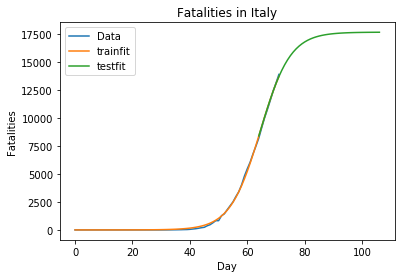

In [105]:
#Below are examples of the predicated results from the model.
dfItaly = pd.merge(train_calc,train[train["Country"]=="Italy"],on="Id")
predFatalitiesItaly = pd.merge(test_calc,test[test["Country"]=="Italy"],on="ForecastId")["Fatalities"]
plt.plot(dfItaly.index,dfItaly['Fatalities_y'],label='Data')
plt.plot(dfItaly.index,dfItaly['Fatalities_x'],label='trainfit')
plt.plot(dfItaly.index[-1]-7+predFatalitiesItaly.index,predFatalitiesItaly,label='testfit')
plt.legend()
plt.ylabel('Fatalities')
plt.xlabel('Day')
plt.title("Fatalities in Italy")

Text(0.5, 1.0, 'Fatalities in Spain')

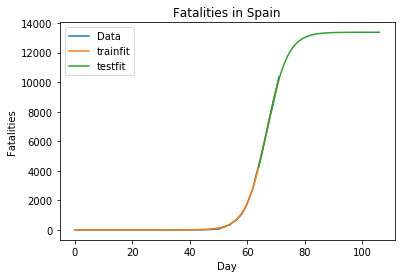

In [116]:
dfSpain = pd.merge(train_calc,train[train["Country"]=="Spain"],on="Id")
predFatalitiesSpain = pd.merge(test_calc,test[test["Country"]=="Spain"],on="ForecastId")["Fatalities"]
plt.plot(dfSpain.index,dfSpain['Fatalities_y'],label='Data')
plt.plot(dfSpain.index,dfSpain['Fatalities_x'],label='trainfit')
plt.plot(dfSpain.index[-1]-7+predFatalitiesSpain.index,predFatalitiesSpain,label='testfit')
plt.legend()
plt.ylabel('Fatalities')
plt.xlabel('Day')
plt.title("Fatalities in Spain")

#### Results
This notebook placed in the top 17%. The above examples show that the logistic curve fit on the training data fit quite well, as the lines are almost on top of each other.  

#### Other approaches:
Time series data is often modeled with Auto Regressive Integrated Moving Average (ARIMA). However, the data inherent is unstable, as the second derivative does not go to zero, and succesive differencing would not improve this issue. Therefore, ARIMA does not apply. Another alternative approach would have been to do linear regression on a moving window, using each of the previous data points in as a weight to predict the future steps. Given more time, this possibility could be worth exploring. 